In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation

In [ ]:
data = pd.read_csv('/content/training_set.csv')

In [ ]:
X = data.drop('SOURCE', axis=1)
y = data['SOURCE']

In [ ]:
# use one-hot encoding to convert 'string' to numerical values
X = pd.get_dummies(X, columns = ['SEX'], drop_first=True)

# Model Training

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, random_state=42)

In [ ]:
rfc = RandomForestClassifier(random_state = 42)

rfc.fit(X_train, y_train)

y_train_pred = rfc.predict(X_train)
y_val_pred = rfc.predict(X_val)
y_test_pred = rfc.predict(X_test)

# 報告
print("=== RFC Training Report ===")
print(classification_report(y_train, y_train_pred))

print("=== RFC Validation Report ===")
print(classification_report(y_val, y_val_pred))

print("=== RFC Test Report ===")
print(classification_report(y_test, y_test_pred))

=== RFC Training Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1403
           1       1.00      1.00      1.00       913

    accuracy                           1.00      2316
   macro avg       1.00      1.00      1.00      2316
weighted avg       1.00      1.00      1.00      2316

=== RFC Validation Report ===
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       197
           1       0.78      0.67      0.72       134

    accuracy                           0.79       331
   macro avg       0.79      0.77      0.78       331
weighted avg       0.79      0.79      0.79       331

=== RFC Test Report ===
              precision    recall  f1-score   support

           0       0.73      0.84      0.78       392
           1       0.70      0.54      0.61       270

    accuracy                           0.72       662
   macro avg       0.71      0.69      0.69   

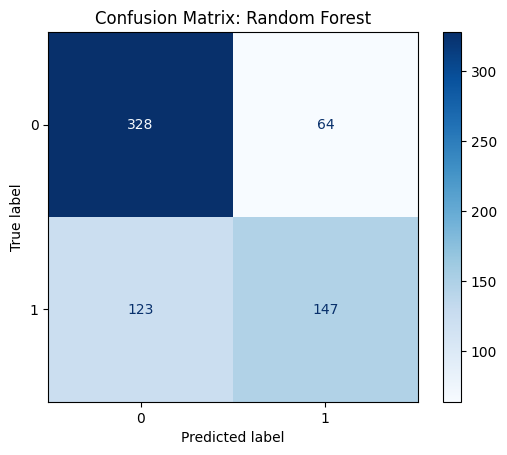

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix: Random Forest")
plt.show()

# Tune the parameters

In [ ]:
param_grid = {
    'n_estimators': [50, 100],  # Number of trees
    'max_depth': [None, 3, 9, 15],  # Maximum depth of trees
    'min_samples_split': [2, 5, 8],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider for best split
}

In [ ]:
# Set up GridSearchCV to tune parametes automatically and find the best combination
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,              # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,         # Use all available cores
    verbose=1
)

grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.7543187234676398


In [ ]:
# Evaluate the model on validation set
best_rf = grid_search.best_estimator_
val_predictions = best_rf.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation accuracy: {val_accuracy:.4f}")

# Evaluate on test set
test_predictions = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test accuracy: {test_accuracy:.4f}")
print("\nClassification Report on Test Set:")
print(classification_report(y_test, test_predictions))

Validation accuracy: 0.7885
Test accuracy: 0.7266

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       392
           1       0.72      0.54      0.62       270

    accuracy                           0.73       662
   macro avg       0.72      0.70      0.70       662
weighted avg       0.73      0.73      0.72       662



**Tuning Result**

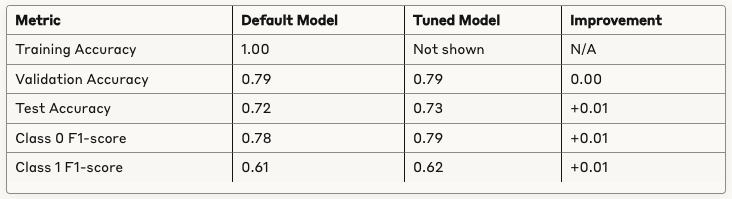

After tuning, only a slight improvement was made (1%) in test accuracy, class 0, and class 1 F1 score.

1. Parameters analysis :


*  n_estimators (100): This parameter determines how many trees are in the forest. The default is usually 100, but the tuning process confirmed this was optimal. More trees generally lead to better performance but with diminishing returns.
*  min_samples_split (5): Increasing this from the default of 2 means nodes only split if they have at least five samples, making individual trees more robust against noise in the data.
* max_depth (None): Interestingly, the tuning process found that allowing trees to grow to their full depth worked best. This differs from the decision tree, where limiting depth was crucial. This might be because random forests are inherently less prone to overfitting due to their ensemble nature.

2. Conclusion: The random forest model shows less overfitting than the decision tree, even with default parameters. While the decision tree needed significant tuning to improve from 0.64 to 0.70 test accuracy, the random forest started at 0.72 and improved slightly to 0.73.

 Since the model had a slight overfitting problem, the most influential parameters were **n_estimators** and **min_samples_leaf**.

 The n_estimators parameter (100) controls how many trees are in the forest, with more trees helping to reduce overfitting by averaging out noise. The min_samples_leaf parameter affects how specific each tree's leaf nodes can be, with higher values creating more general rules that better generalize to new data.


# Feature Importance

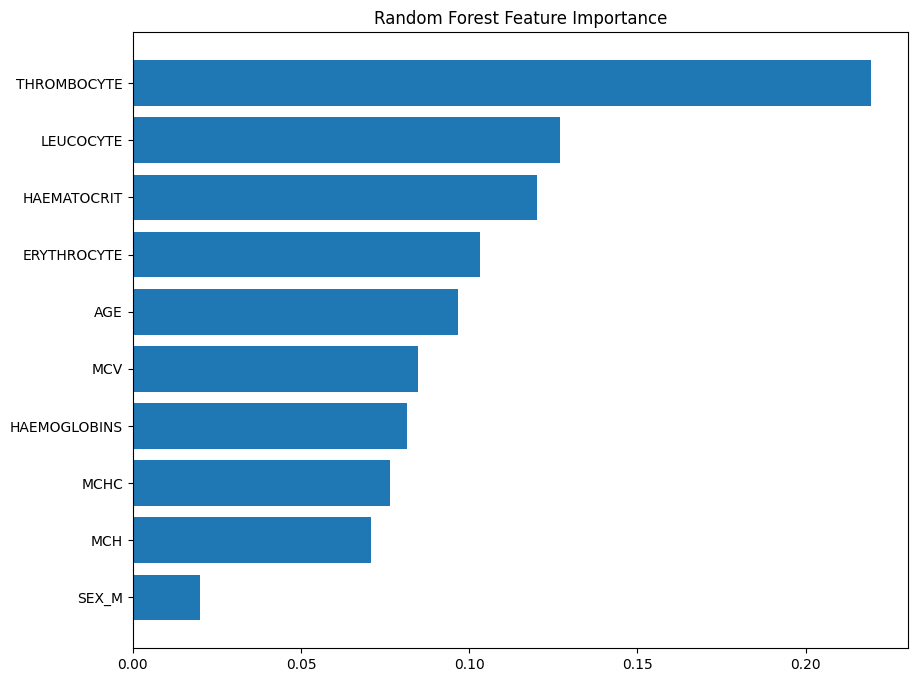

In [ ]:
# Feature importance analysis
feature_importance = best_rf.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title('Random Forest Feature Importance')
plt.show()

In [ ]:
important_df = pd.DataFrame({
    'Feature':feature_names,
    'Importance':feature_importance
})
important_df.sort_values(by='Importance', ascending=False)
important_df

,Feature,Importance
0,HAEMATOCRIT,0.120261
1,HAEMOGLOBINS,0.081384
2,ERYTHROCYTE,0.103353
3,LEUCOCYTE,0.126846
4,THROMBOCYTE,0.219429
5,MCH,0.070947
6,MCHC,0.076427
7,MCV,0.084913
8,AGE,0.096521
9,SEX_M,0.019918


In [ ]:
threshold = 0.05

selected_features = important_df[important_df['Importance'] > threshold]['Feature'].tolist()

In [ ]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
X_val_selected = X_val[selected_features]

best_rf.fit(X_train_selected, y_train)
selected_test_preds = best_rf.predict(X_test_selected)
selected_test_acc = accuracy_score(y_test, selected_test_preds)

print("\n--- Model with Selected Features Performance ---")
print(f"Test Accuracy: {selected_test_acc:.4f}")
print("\nClassification Report (Feature-Selected Model):")
print(classification_report(y_test, selected_test_preds))


--- Model with Selected Features Performance ---
Test Accuracy: 0.7417

Classification Report (Feature-Selected Model):
              precision    recall  f1-score   support

           0       0.74      0.86      0.80       392
           1       0.74      0.56      0.64       270

    accuracy                           0.74       662
   macro avg       0.74      0.71      0.72       662
weighted avg       0.74      0.74      0.73       662



**Feature Selection Report**

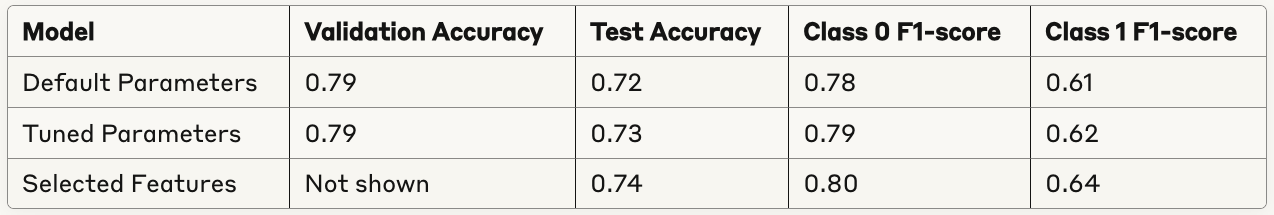

I trained the selected features (threshold = 0.05) with the optimized model (the model with tuned parameters). Since there are only 10 features, I set the threshold to 0.05 to extract features. Random forest model with feature selection improved slightly from 0.73 to 0.74 in test accuracy. Surprisingly, it also improved in class 1 F1-score, which was the more challenging to predict. For the random forest model, it builds many independent trees that vote together. With fewer but better features, more trees focus on the strongest signals. This reduced the 'noises' from less essential trees. The ensemble becomes more accurate, especially for the challenging class 1.

# Different sizes of the available dataset

Since the random forest model performs the best in test accuracy, class 0 and class 1 F1-score, I decided to choose this model to observe how different sizes of the dataset affect the model's performance.

In [ ]:
X_remaining, X_test, y_remaining, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [ ]:
training_sizes = []
accuracy = []

for size in range(90, 0, -10):
  sample_size = int(len(X_remaining) * (size/100))

  # randomly pick the datapoints
  indices = np.random.choice(len(X_remaining), sample_size, replace=False)
  X_sample = X_remaining.iloc[indices]
  y_sample = y_remaining.iloc[indices]

  best_rf.fit(X_sample, y_sample)

  y_pred = best_rf.predict(X_test)
  acc = accuracy_score(y_test, y_pred)

  accuracy.append(acc)
  training_sizes.append(sample_size)

  print(f"Training size: {sample_size} samples ({size}%) - Accuracy: {acc:.4f}")



Training size: 2680 samples (90%) - Accuracy: 0.7492
Training size: 2382 samples (80%) - Accuracy: 0.7553
Training size: 2084 samples (70%) - Accuracy: 0.7281
Training size: 1786 samples (60%) - Accuracy: 0.7402
Training size: 1489 samples (50%) - Accuracy: 0.7341
Training size: 1191 samples (40%) - Accuracy: 0.7492
Training size: 893 samples (30%) - Accuracy: 0.7100
Training size: 595 samples (20%) - Accuracy: 0.7492
Training size: 297 samples (10%) - Accuracy: 0.6798


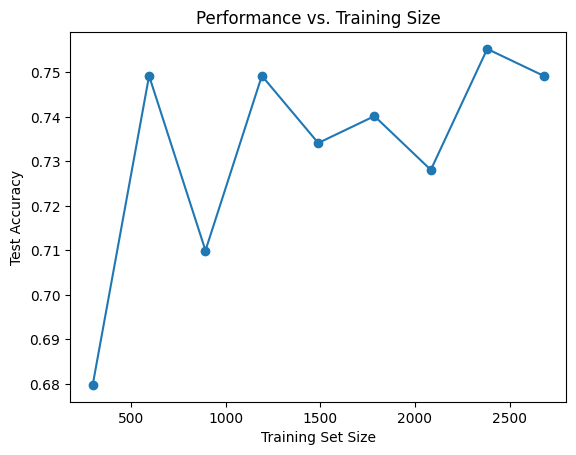

In [ ]:
plt.plot(training_sizes, accuracy, marker = 'o')
plt.xlabel("Training Set Size")
plt.ylabel("Test Accuracy")
plt.title("Performance vs. Training Size")
plt.show()

By training this method several times, the results showed a positive correlation between training set size and test accuracy. As we increase the amount of training data from 10% to 90% of the dataset, the model's performance generally improves. However, we can see that the improvement is not perfectly linear, suggesting there may be a point of which additional data provides minimal benefit. Besides, the random sampling also shows some variability in model performance. Overall, the highest test accuracy mostly appear in the upper range of training set sizes (around 70-90% of available data), confirming that using more training data is beneficial to this problem.